# Timing comparisons with lacosmic and astroscrappy

In this notebook, we compare dfcosmic (both CPU and GPU implementations) with [lacosmic](https://github.com/larrybradley/lacosmic) and [astroscrappy](https://github.com/astropy/astroscrappy). 

These tests were run using a System76 Adder WS with a Intel® Core™ i9-14900HX × 32 and a NVIDIA GeForce RTX 4060 Laptop GPU.

The code snippet for generating fake data was taken **directly** from [astroscrappy tests](https://github.com/astropy/astroscrappy/blob/main/astroscrappy/tests/fake_data.py); therefore, we thank them.

The fake data is set to have the approximate size as a standard narrowband observation taken with Mothra (6000 x 4000).

In [1]:
import time
import torch
import numpy as np
from lacosmic.core import lacosmic
from astroscrappy import detect_cosmics
from dfcosmic import lacosmic as df_lacosmic
from threadpoolctl import threadpool_limits
import matplotlib.pyplot as plt

In [2]:
num_threads = [1, 2, 4, 8, 16]

In [3]:
# Make a simple Gaussian function for testing purposes
def gaussian(image_shape, x0, y0, brightness, fwhm):
    x = np.arange(image_shape[1])
    y = np.arange(image_shape[0])
    x2d, y2d = np.meshgrid(x, y)

    sig = fwhm / 2.35482

    normfactor = brightness / 2.0 / np.pi * sig**-2.0
    exponent = -0.5 * sig**-2.0
    exponent *= (x2d - x0) ** 2.0 + (y2d - y0) ** 2.0

    return normfactor * np.exp(exponent)


def make_fake_data(size=(6000, 4000)):
    """
    Generate fake data that can be used to test the detection and cleaning algorithms

    Returns
    -------
    imdata : numpy float array
        Fake Image data
    crmask : numpy boolean array
        Boolean mask of locations of injected cosmic rays
    """
    # Set a seed so that the tests are repeatable
    np.random.seed(200)

    # Create a simulated image to use in our tests
    imdata = np.zeros(size, dtype=np.float32)

    # Add sky and sky noise
    imdata += 200

    psf_sigma = 3.5

    # Add some fake sources
    for i in range(100):
        x = np.random.uniform(low=0.0, high=1001)
        y = np.random.uniform(low=0.0, high=1001)
        brightness = np.random.uniform(low=1000.0, high=30000.0)
        imdata += gaussian(imdata.shape, x, y, brightness, psf_sigma)

    # Add the poisson noise
    imdata = np.float32(np.random.poisson(imdata))

    # Add readnoise
    imdata += np.random.normal(0.0, 10.0, size=size)

    # Add 100 fake cosmic rays
    cr_x = np.random.randint(low=5, high=995, size=100)
    cr_y = np.random.randint(low=5, high=995, size=100)

    cr_brightnesses = np.random.uniform(low=1000.0, high=30000.0, size=100)

    imdata[cr_y, cr_x] += cr_brightnesses
    imdata = imdata.astype("f4")

    # Make a mask where the detected cosmic rays should be
    crmask = np.zeros(size, dtype=bool)
    crmask[cr_y, cr_x] = True
    return imdata, crmask

In [4]:
# Make fake data
imdata, expected_crmask = make_fake_data()

Run the code using our four options:

1. `dfcosmic` on the CPU
2. `dfcosmic` on the GPU
3. `astroscrappy` with `sepmed=True`
4. `astroscrappy` with `sepmed=False`
5. `lacosmic`

Option 1: `dfcosmic` on the CPU

In [5]:
dfcosmic_cpu = []
for n_threads in num_threads:
    torch.set_num_threads(n_threads)
    start_dfcosmic_cpu = time.perf_counter()
    clean, crmask = df_lacosmic(
        image=imdata,
        objlim=2,
        sigfrac=1,
        sigclip=6,
        gain=1,
        readnoise=10,
        niter=1,
        device="cpu",
    )

    elapsed_dfcosmic_cpu = time.perf_counter() - start_dfcosmic_cpu
    dfcosmic_cpu.append(elapsed_dfcosmic_cpu)

In [6]:
dfcosmic_cpu_torch_only = []

for n_threads in num_threads:
    torch.set_num_threads(n_threads)
    start_dfcosmic_cpu_torch_only = time.perf_counter()
    clean, crmask = df_lacosmic(
        image=imdata,
        objlim=2,
        sigfrac=1,
        sigclip=6,
        gain=1,
        readnoise=10,
        niter=1,
        device="cpu",
        use_cpp=False,
    )

    elapsed_dfcosmic_cpu_torch_only = (
        time.perf_counter() - start_dfcosmic_cpu_torch_only
    )
    dfcosmic_cpu_torch_only.append(elapsed_dfcosmic_cpu_torch_only)

Option 2: `dfcosmic` on the GPU

In [7]:
dfcosmic_gpu = []
for n_threads in num_threads:
    torch.set_num_threads(n_threads)
    start_dfcosmic_gpu = time.perf_counter()
    clean, crmask = df_lacosmic(
        image=imdata,
        objlim=2,
        sigfrac=1,
        sigclip=6,
        gain=1,
        readnoise=10,
        niter=1,
        device="cuda",
    )

    elapsed_dfcosmic_gpu = time.perf_counter() - start_dfcosmic_gpu
    dfcosmic_gpu.append(elapsed_dfcosmic_gpu)

Option 3: Astroscrappy with `sepmed=True`

In [8]:
astroscrappy_sepmed_true = []
for n_threads in num_threads:
    with threadpool_limits(limits=n_threads):
        start_astroscrappy = time.perf_counter()
        _, _ = detect_cosmics(
            imdata,
            readnoise=10.0,
            gain=1.0,
            sigclip=6,
            sigfrac=1.0,
            objlim=2,
            sepmed=True,
        )
        elapsed_astroscrappy = time.perf_counter() - start_astroscrappy
        astroscrappy_sepmed_true.append(elapsed_astroscrappy)

Option 4: Astroscrappy with `sepmed=False`

In [9]:
astroscrappy_sepmed_false = []
for n_threads in num_threads:
    with threadpool_limits(limits=n_threads):
        start_astroscrappy = time.perf_counter()
        _, _ = detect_cosmics(
            imdata,
            readnoise=10.0,
            gain=1.0,
            sigclip=6,
            sigfrac=1.0,
            objlim=2,
            sepmed=False,
        )
        elapsed_astroscrappy = time.perf_counter() - start_astroscrappy
        astroscrappy_sepmed_false.append(elapsed_astroscrappy)

Option 5: `lacosmic`

In [10]:
lacosmic_results = []
for n_threads in num_threads:
    with threadpool_limits(limits=n_threads):
        start_lacosmic = time.perf_counter()
        clean, crmask = lacosmic(
            data=imdata,
            contrast=2,
            neighbor_threshold=6,
            cr_threshold=1,
            effective_gain=1,
            readnoise=10,
            maxiter=1,
        )

        elapsed_lacosmic = time.perf_counter() - start_lacosmic
        lacosmic_results.append(elapsed_lacosmic)

INFO: Iteration 1: Found 100 cosmic-ray pixels, Total: 100 [lacosmic.core]
INFO: Iteration 1: Found 100 cosmic-ray pixels, Total: 100 [lacosmic.core]
INFO: Iteration 1: Found 100 cosmic-ray pixels, Total: 100 [lacosmic.core]
INFO: Iteration 1: Found 100 cosmic-ray pixels, Total: 100 [lacosmic.core]
INFO: Iteration 1: Found 100 cosmic-ray pixels, Total: 100 [lacosmic.core]


## Plot of times

The plot will be broken down in the following manner:
 - the x-axis shows the number of available threads
 - the y-axis is the execution time in seconds
 - the color indicates the option

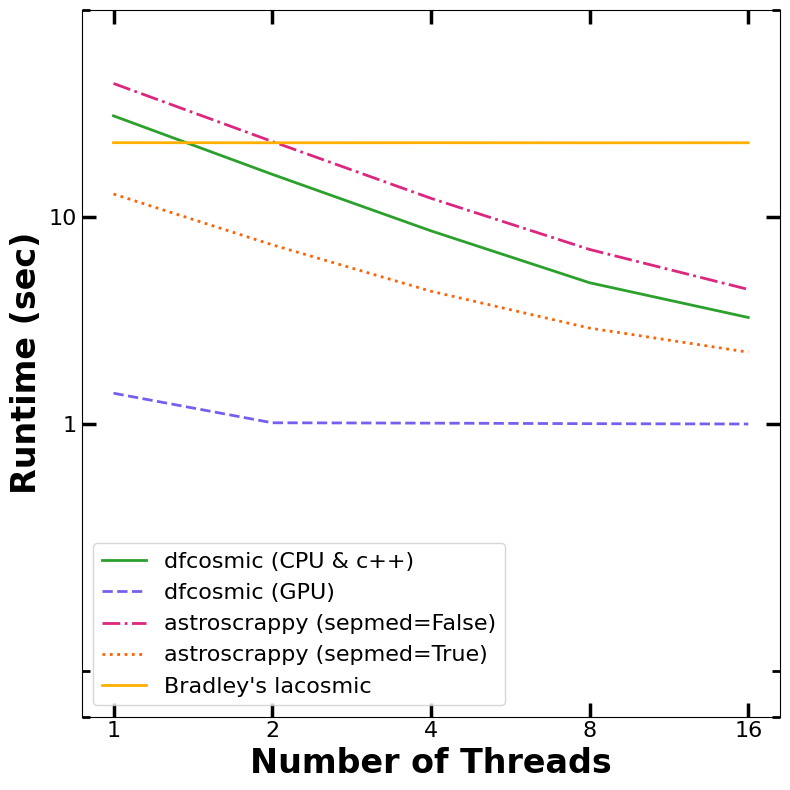

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

colors = [
    "#2CA02C",  # Green
    "#0B47DF",  # Blue
    "#785EF0",  # Purple
    "#DC267F",  # Magenta
    "#FE6100",  # Orange
    "#FFB000",  # Yellow
]

fig, ax = plt.subplots(figsize=(8, 8))  # square

ax.plot(
    num_threads, dfcosmic_cpu,
    label="dfcosmic (CPU & c++)",
    c=colors[0], linewidth=2, linestyle="-",
)

ax.plot(
    num_threads, dfcosmic_gpu,
    label="dfcosmic (GPU)",
    c=colors[2], linewidth=2, linestyle="--",
)

ax.plot(
    num_threads, astroscrappy_sepmed_false,
    label="astroscrappy (sepmed=False)",
    c=colors[3], linewidth=2, linestyle="-.",
)

ax.plot(
    num_threads, astroscrappy_sepmed_true,
    label="astroscrappy (sepmed=True)",
    c=colors[4], linewidth=2, linestyle=":",
)

ax.plot(
    num_threads, lacosmic_results,
    label="Bradley's lacosmic",
    c=colors[5], linewidth=2,
)

ax.set_xlabel("Number of Threads", fontweight="bold", fontsize=24)
ax.set_ylabel("Runtime (sec)", fontweight="bold", fontsize=24)

# --- X axis: make it truly logarithmic (base 2) so 1,2,4,8,16 are equally spaced ---
ax.set_xscale("log", base=2)
ax.set_xticks([1, 2, 4, 8, 16])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))

# Optional: minor ticks at 3,5,6,7,9,... *in the right places on a log axis*
# (Uncomment if you want them)
# ax.xaxis.set_minor_locator(mticker.LogLocator(base=2, subs=(1.5, 1.25, 1.75)))
# ax.xaxis.set_minor_formatter(mticker.NullFormatter())

# --- Y axis: add visible whitespace under the GPU curve ---
# symlog behaves like log for larger values, but is linear close to 0 so the bottom isn't crushed.
ax.set_yscale("symlog", linthresh=0.5)   # adjust linthresh (0.2, 0.5, 1.0) to taste
ax.set_ylim(0, 100)                      # include 0 to create bottom breathing room

# Keep the "1" and "10" labeling you wanted
ax.set_yticks([1, 10])
ax.set_yticklabels(["1", "10"], fontsize=16)

# --- Ticks inside + larger tick marks ---
ax.tick_params(
    axis="both",
    which="major",
    direction="in",
    labelsize=16,
    length=10,   # bigger
    width=2.5,   # thicker
    top=True,
    right=True,
)
ax.tick_params(
    axis="both",
    which="minor",
    direction="in",
    length=6,
    width=2,
    top=True,
    right=True,
)

ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig("comparison.png", dpi=300)
